# A basic introduction to Data Science
**Disclaimer:** This is not a full introduction and unashamedly focusses on the areas I'm most interested in (optimisation). We are going to spend a small amount of time looking at howto extract data contained in text files. The focus is then on giving you an introduction to how some of the machine learning algorithms work under the hood (rather than just calling the existing implementations from a library). Overall this is very basic though, with a thorough treatment requiring at least a semester course. 

## Scenario
In this exerercise we are going to work through a fairly common scenario. After developing a couple of algorithms for solving a particular problem (or implementing some "standard" algorithms as well as your shiny new and hopefully improved algorithm), you test the algorithm on some instances and want to know which algorithm is "best"? Or which algorithm is best for what type of data? 

Here we are going to go through this type of analysis by focussing on alternative linear programming algorithms. So here are the elements that go into the analysis:
* The problem to be solved:  $\min c^T x$ subject to $A x = b,\ x \ge 0$ where $A$ is a $m\times n$ matrix, $x$ is a vector of decision variables and $b$ and $c$ are appropriate constant vectors. In practice we normally allow some variants (for example inequality constraints, arbitrary lower and upper bounds on the variables). 
* Algorithms: Three standard algorithms, *primal* simplex, *dual* simplex, and the *barrier* method, as implemented by the CPLEX solver library
* Instances: The [MIPLIB2010](http://miplib2010.zib.de/) "standard" test instances. The data sets are actually for mixed integer problems (where some variables are required to be binary or general integers), but for these tests we will throw away the binary requirements. There are 87 instances in this data set

To make things easy you will not be required to re-run all of the tests but are given the results from running each algorithm on each instance.

## Getting the data
In an ideal world the data would already be sitting in a database or simple CSV file for you to read. However this may not always be possible. It is not uncommon for the data to be sitting in text files (perhaps the log files produced as the algorithms are run). Since such text files can get quite large, it makes sense to compress these. 

Your first task then is to obtain the data and display a few lines of one of the log files to see what these look like.
That data can be found as a zip file at http://users.monash.edu/~andrease/Files/Other/cplexLP.zip. You could download this, unzip it and look at it - but we want to do things with python here. The basic library functions you need are
* `urllib` using the `urllib.request.urlopen("name.of.url/to-load")` function. Basic usage information is provided in this [how-to](https://docs.python.org/3.6/howto/urllib2.html?highlight=get%20url). It is probably easiest to just read this data and write it to file.
* `zipfile` module provides methods for reading (and writing) zip archives. The basic usage is to create `zip=ZipFile(<file>,'r')` archive, then use `zip.namelist()` to inspect the contents and `zip.open(name,'r')` to open the named file. Complete documentation is [here](https://docs.python.org/3/library/zipfile.html)
* Note that all log files are ASCII. To convert a binary (ASCII) string to the standard python unicode string use `.decode("utf-8")`

In [1]:
from urllib.request import urlopen

location = "http://users.monash.edu/~andrease/Files/Other/cplexLP.zip"
open("cplexLP.zip","bw").write(urlopen(location).read())


519756

In [2]:
from zipfile import ZipFile
zip = ZipFile("cplexLP.zip","r")
print("Zip file contains","; ".join(zip.namelist()[:4]),"...")
print(zip.open(zip.namelist()[0],"r").read().decode("utf-8"))

Zip file contains cplexLP/30n20b8.barrier.log; cplexLP/30n20b8.dual.log; cplexLP/30n20b8.primal.log; cplexLP/acc-tight5.barrier.log ...

Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 12.8.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2017.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Selected objective sense:  MINIMIZE
Selected objective  name:  Obj
Selected RHS        name:  rhs
Selected bound      name:  bnd
Problem '/max-software/data/miplib2010/instances/30n20b8.mps.bz2' read.
Read time = 0.23 sec. (11.86 ticks)
CPLEX> Problem changed to LP.
CPLEX> Problem name         : /max-software/data/miplib2010/instances/30n20b8.mps.bz2
Objective sense      : Minimize
Variables            :   18380  [Fix: 7282,  Box: 11098]
Objective nonzeros   :       2
Linear constraints   :     5

## Extracting Features
For each instance we want to extract the following information:
* The name (identifier) for the data set. This is encoded in the name of each file in the Zip archive (after the cplexLP/) or in the log file itself as part of the "Problem name"
* Characteristics or *features* of the instance to be solved. The log file contains some "statistics" of the problem such as the number of constraints and variables, number of non-zero coefficients, etc. See the CPLEX documentation on [displaying problem statistics](https://www.ibm.com/support/knowledgecenter/SSSA5P_12.8.0/ilog.odms.cplex.help/CPLEX/GettingStarted/topics/tutorials/InteractiveOptimizer/displayingProbStats.html) for more informaiton
* The solution algorithm used: this is again shown in the "Problem name" or can be seen as an integer in the log file as "method for linear optimisation" (1=primal, 2=dual, 4=barrier)
* The time required using the solution algorithm: You could take the solution time in seconds, but for the analysis here using the "Deterministic time" in "ticks" is likely to be more useful as a way of assessing which algorithm is more efficient. Having said that, you may also want to extract the time in seconds. See this brief [discussion on ticks](http://www.thequestforoptimality.com/deterministic-behavior-of-cplex-ticks-or-seconds/) or CPLEX [documentation](https://www.ibm.com/support/knowledgecenter/SSSA5P_12.8.0/ilog.odms.cplex.help/CPLEX/Parameters/topics/DetTiLim.html) for a little more information about what these mysterious ticks mean

In particular from the section of the log files that looks like this:
```
Objective sense      : Minimize
Variables            :   18380  [Fix: 7282,  Box: 11098]
Objective nonzeros   :       2
Linear constraints   :     576  [Less: 486,  Equal: 90]
  Nonzeros           :  109706
  RHS nonzeros       :      30

Variables            : Min LB: 0.000000         Max UB: 212.0000       
Objective nonzeros   : Min   : 51.00000         Max   : 100.0000       
Linear constraints   :
  Nonzeros           : Min   : 1.000000         Max   : 224.0000       
  RHS nonzeros       : Min   : 1.000000         Max   : 1.000000     

...lines deleted...

Deterministic time = 296.40 ticks  (956.13 ticks/sec)
```
We want to extract: the fields: VarCnt, VarFix,VarBox, ObjNZ,ConNZ, ConLess, ConEqual, ConNZ, RhsNZ, VarMin,VarMax,ObjMin,ObjMax,ConMin,ConMax,RhsMin,RhsMax,PrimalT (or DualT or BarrierT for the ticks)

### Python functions and libraries to use

When dealing with text files, regular expressions are your friend. They form a mini-language of their own for expressing string patterns. Regular expressions are not unique to python, with relatively similar syntax used in a variety of tools (particularly in linux/unix). The [regular expression documentation](https://docs.python.org/3/library/re.html) gives all the details, but to get you started the string `r"^[abc]\d*"` would match any line that 
   * is at the start of a line (as incdicated by the `^`)
   * has one of the characters in the set {'a','b','c'} (written as "[abc]") first
   * is followed by zero or more digits "\d" = digit, * means "zero or more", you could use "+" for "one or more"
   * the string is written as a raw string (`r""`) to make sure that "\" is not interpreted as an escape character - since regular expressions make frequent use of the backslash
   * it is also particularly useful and easy to mark a substring as a _group_. For example `r"([xyz]+)\1"` means that we have a group consisting of one or more characters in {x,y,z} followed by the same group (group 1) repeating a second time. 
   * `import re` to get the library, then use `re.search(pattern,string)` to find a pattern in the given string, `re.search(pattern,string).group(1)` would give the substring of the first group in the time the pattern was matched (if the pattern was found at all).

#### Regular expression testing
To test your skills at writing regular expressions, try the following exercises:

In [104]:
import re
def testre(regex,string):
    matches = re.findall(regex,string)
    print("%d:"%len(matches),";".join(matches))
    return matches
          
testre(r"[A-Z]\w+", # insert regular expressions to find any capitalised words with 2 letters or more
    """Some words, like Australia I know, have Capital letters, see Figure 3 for more"""
    )# should find 4: Some;Australia;Capital;Figure
testre(r"\\begin{(\w+)}[^@]*\\end{\1}", # outer LaTeX environments: \begin{somename}up to\end{somename}
      r"""\begin{enumerate}\item
      \end{enumerate}\begin{nested}\begin{env}\end{env}\end{nested}
      \begin{test}\end{fail}  \begin{array}1 & 2\\3 & 4 \\end{array}
      """) # should find 3: enumerate;nested;array
[float(f) for f in 
 testre(r"[-+]?\d+[.]?\d*[eE][-+]?\d+|[-+]?\d+[.]?\d*|NaN", 
        # find floating point numbers (including integers and scientific notation)
      "15.3 - -100 1.2e-03  NaN 1ee4 +2E+6 ")  # 7: 15.3;-100;1.2e-03;NaN;1;4;+2E+6
] # output 15.3, -100.0, 0.0012, nan, 1.0, 4.0, 2000000.0]

4: Some;Australia;Capital;Figure
3: enumerate;nested;array
7: 15.3;-100;1.2e-03;NaN;1;4;+2E+6


[15.3, -100.0, 0.0012, nan, 1.0, 4.0, 2000000.0]

#### Extracting the data

Have a go at extracting some/all of the data. Store the data in a pandas `DataFrame` object. See the [10 minute introduction](http://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html) to Pandas if you have not come across this before. Essentially it is a "table like" data structure that makes it easy to manipulate data. 


In [6]:
import re,pandas
import numpy as np

probrex = re.compile(r"cplexLP/([^.]+)\.([a-z]+)\.log")
Instance = { probrex.match(d).group(1):{} for d in zip.namelist()}
for d in zip.namelist(): 
    m=probrex.match(d)
    Instance[m.group(1)][m.group(2)]=d
cntrex = re.compile(r"^(Variables|Linear)[^:]+: *(\d+) *(\[.*\])? *$")
floatmap={"all infinite":1e20,"all zero":0.0}
floatrex = r"-?\d+\.?\d*e?[-+0-9]*|all infinite|all zero" # cover the rare case of infinity
rangerex=re.compile(r"^ *(\w+).*: +Min.*: +("+floatrex+r") +Max.*: +("+floatrex+")")
rangemap={"Variables":"Var","Objective":"Obj","Nonzeros":"Con","RHS":"Rhs"}
nzmap = {"Objective":"ObjNZ", "Nonzeros":"ConNZ","RHS" : "RhzNZ" }
nzrex = re.compile(r"^ *("+"|".join(nzmap.keys())+r")[^:]*: *(\d+)$")
data = {} # list of records
for inst in Instance:
    res = {} # result
    continuation = ""
    for line in zip.open(Instance[inst]["primal"],"r"): # read the statistics
        line = continuation + line.decode("utf-8") # in case line is continuing
        continuation = ""
        if "[" in line and not "]" in line:
            continuation = line.strip()
            continue
        m = cntrex.match(line)
        if m:
            base = "Var" if m.group(1)=="Variables" else "Con"
            res[base+"Cnt"] = int(m.group(2))
            if m.group(3):
                for name,val in [i.split(": ") for i in re.split(", *",m.group(3).strip("[]"))]:
                    res[base+name]=int(val)
            continue
        m = rangerex.match(line)
        if m:
            base = rangemap[m.group(1)]
            res[base+"Min"] = float(-floatmap[m.group(2)] if "all" in m.group(2) else m.group(2))
            res[base+"Max"] = float(floatmap[m.group(3)] if "all" in m.group(3) else m.group(3))
            continue
        m = nzrex.match(line)
        if m: res[nzmap[m.group(1)]] = int(m.group(2))
    # end loop over lines in primal data file
    for method in ["primal","dual","barrier"]:
        res[method.capitalize()+"T"]= float([
            line for line in zip.open(Instance[inst][method]) # read every line
            if line.startswith(b"Deterministic time = ")][0] #only pick the (one and only) matching line
        .split()[3]) # 3rd field of line is ticks
    data[inst] = res
data = pandas.DataFrame.from_dict(data,orient="index") # could just do DataFrame(data) but that would give us the transpose of what we want
# Now just fix up missing values for the various counts and make sure they are integers
for key in data: 
    if key[:3] in ["Var","Con"] and key[-3:] not in ["Min","Max"]: 
        data[key].fillna(0,inplace=True)
        data[key] = data[key].astype(int) # integer type
data # display data frame

,VarCnt,VarFix,VarBox,ObjNZ,ConCnt,ConLess,ConEqual,ConNZ,RhzNZ,VarMin,...,ConMax,RhsMin,RhsMax,PrimalT,DualT,BarrierT,ConGreater,VarNneg,VarOther,VarFree
30n20b8,18380,7282,11098,2,576,486,90,109706,30,0.0,...,2.240000e+02,1.000000e+00,1.000000e+00,65.00,54.04,296.40,0,0,0,0
acc-tight5,1339,0,1339,1,3052,1106,277,16134,1402,0.0,...,1.000000e+00,1.000000e+00,4.000000e+00,699.24,409.07,723.36,1669,0,0,0
aflow40b,2728,0,2728,1364,1442,1364,78,6783,78,0.0,...,1.000000e+02,1.000000e+00,1.000000e+01,7.54,24.45,11.87,0,0,0,0
air04,8904,0,8904,8904,823,0,823,72965,823,0.0,...,1.000000e+00,1.000000e+00,1.000000e+00,2341.27,707.94,508.64,0,0,0,0
app1-2,26871,0,13300,266,53467,26600,13301,199175,26867,0.0,...,1.000000e+00,1.000000e-05,1.000000e+00,5246.20,5208.74,5748.80,13566,13571,0,0
ash608gpia-3col,3651,0,3651,3,24748,23532,1216,74244,1216,0.0,...,1.000000e+00,1.000000e+00,1.000000e+00,5032.37,86.41,794.84,0,0,0,0
bab5,21600,0,21600,12328,4964,3635,1329,155520,320,0.0,...,8.000000e+00,1.000000e+00,4.510000e+01,465.46,1953.01,1070.48,0,0,0,0
beasleyC3,2500,0,1250,1250,1750,1250,500,5000,83,0.0,...,8.200000e+01,1.000000e+00,8.200000e+01,3.54,5.49,7.70,0,1250,0,0
biella1,7328,0,6110,7328,1203,5,1197,71489,1202,0.0,...,1.000000e+08,1.000000e+00,1.000000e+10,1821.30,1215.44,607.91,1,1218,0,0
bienst2,505,0,56,1,576,392,128,2184,72,0.0,...,8.100000e+01,2.000000e+00,1.500000e+01,13.62,2.37,10.10,56,449,0,0


In [7]:
# let's just check for missing values
data[np.logical_or.reduce(data.isnull(),axis=1)]#[[key for key in data if not key.endswith("T") and not key.endswith("NZ")]]

,VarCnt,VarFix,VarBox,ObjNZ,ConCnt,ConLess,ConEqual,ConNZ,RhzNZ,VarMin,...,ConMax,RhsMin,RhsMax,PrimalT,DualT,BarrierT,ConGreater,VarNneg,VarOther,VarFree


### Starting with just the data
To make things easy, here is a way to just start with the data you should have by now (you can also skip the above and just start from here).

As a reminder on using data frames, this [pandas selection tutorial](https://medium.com/dunder-data/selecting-subsets-of-data-in-pandas-6fcd0170be9c) provides a good summary on how to access rows,columns etc 

In [1]:
# back up the data so we can reload it easily when required
open("cplexLP.json","w").write(data.to_json())  # or pick your favourite data format...
print('Reload using: data = pandas.read_json(open("cplexLP.json","r"))')

Reload using: data = pandas.read_json(open("cplexLP.json","r"))


## Visualising our data
This is quite high dimensional. How do we make sense of this?
Let's try to do a plot. For this we need to reduce the data to two dimensions. Enter PCA (Principal Component Analysis).
For most of the "machine learning" type algorithms in this workshop we will use the [scikit-learn](https://scikit-learn.org/stable/documentation.html) set of libraries. This inlcudes a [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) method. However so we can see more easily what is going on here, let's do it directly using the numpy matrix routines.
Note: For the PCA we are only interested in the feature columns that _exclude_ the runtime (ticks) with the different methods. We can get a copy of our data that excludes the runtime using
```python
features = data[[key for key in data if not key.endswith("T")]].copy()
```
We might also want to replace the various max/min elements with something more sensible such as the log of the max and min or log of the range (since it is more likely that this magnitutde has an impact than the absolute values).


Useful functions:
* `data.values` gives the whole frame as a matrix. To get sensible results we want to (a) ignore the timing columns (those ending with T) and (b) replace the max/min of various values by the log of the range (difference between max and min);  (c) use the squareroot of ConNZ, since this is expected to be proportional to VarCnt * ConCnt
* We need to form the covariance matrix (subtract the column mean, multiply by the transpose and divide by n-1): $cov= \frac{1}{n-1}(X-I\bar x)^T (X-I\bar x)$. For this you need `np.mean` which takes an argument `axis=d` to take the mean in the d'th dimension, and `X.T` is the transpose of numpy matrix `X`. Or just call `numpy.cov` - but be careful not to get features & observations (columns and rows) mixed up
* `np.linalg.eig(X)` returns the (eigenvalues, eigenvectors) as vector/matrix respectively. 
* We only want to keep the two largest eigenvectors and plot the projection onto these two axes
* I'm assuming you are using matplotlib (`matplotlib.pyplot.scatter`) but you can use anything else for plotting

Question: Is the scaling of the different attributes proposed above sufficient? Shoud we do something more radical?

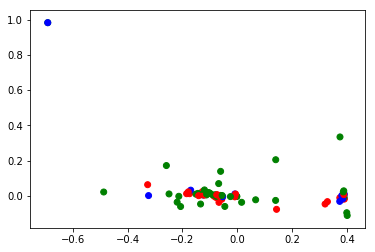

In [125]:
import pandas
data = pandas.read_json(open("cplexLP.json","r")) # reload data

import numpy as np
import matplotlib.pyplot as plt
features = data[[key for key in data if not key.endswith("T") and not key[-3:] in ["Max","Min"]]].copy()
for f in data:
    if f.endswith("Max"):
        features[f.replace("Max","Rng")] = np.log(np.maximum(
            data[f].values-data[f.replace("Max","Min")].values,np.ones(len(data[f].values))*1e-10))
features["ConNZ"] = np.sqrt(features["ConNZ"].values)
# scale everyting to zero-one range
features /= np.max(features,axis=0)-np.min(features,axis=0)
if True: # do it the easy way
    cov = np.cov(features.values,rowvar=False)
else: # compute from first principles
    cov = features.values # raw data
    mean=np.mean(cov,axis=0) # mean of each column
    n = data.shape[0]-1 # number of rows
    cov = (cov-mean).T.dot(cov-mean)/(n-1) # 
λ,V = np.linalg.eig(cov)
# pick eigenvectors corresponding to the two larges magnitude eigenvalues
(_,Vx),(_,Vy) = sorted([ (-abs(v),V[i]) for i,v in enumerate(λ)])[:2]
# pick colours based on which method peforms best
colname=['red','green','blue']
colour=[ min((data[method][i],colname[c]) for c,method in enumerate(['PrimalT','DualT','BarrierT']))[1] 
       for i in range(data.shape[0])]
plt.scatter(features.values.dot(Vx),features.values.dot(Vy),color=colour)
plt.show()

For alternative, more complicated ways to map data down to 2 dimensions there are plenty of other tools in sklearn library (look at [Manifold Learning](https://scikit-learn.org/stable/modules/manifold.html)). However, looking at underlying algoirthms is well beyond the scope of this tutorial.  However you may want to have have a go at a few such as `TSNE` or `MDS`. Note that some of these manifold learning methods are randomised so won't return the same result each time

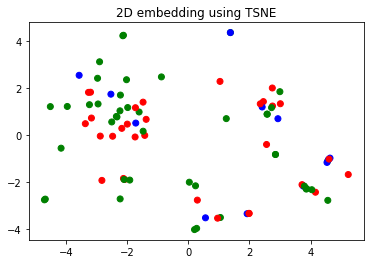

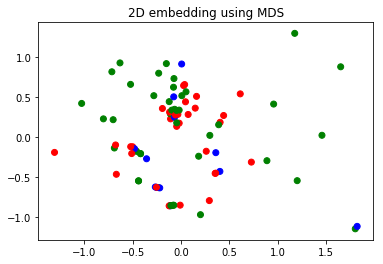

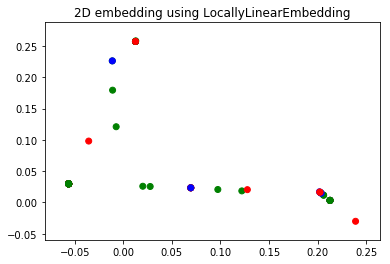

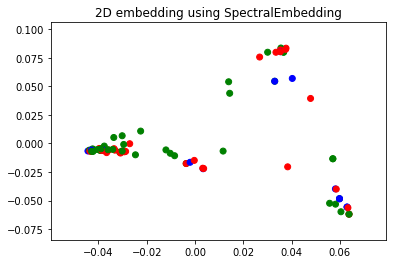

In [133]:
import numpy as np
from sklearn.manifold import TSNE, MDS,LocallyLinearEmbedding,SpectralEmbedding
for embed in ["TSNE", "MDS","LocallyLinearEmbedding","SpectralEmbedding"]:
    pts = eval(embed)(n_components=2).fit_transform(features)
    plt.scatter(pts[:,0],pts[:,1],color=colour)
    plt.title("2D embedding using "+embed)
    plt.show()

## Unsupervised learning - clustering
In unsupervised learning we are looking for some structure without having any real idea of what is "correct". The simplest case of unsupervised learning is clustering - grouping data into clusters of points that are close together. 

The simplest way to do this is to apply the `cluster.KMeans` model from the `scklearn` library. See this [tutorial](https://scikit-learn.org/stable/tutorial/statistical_inference/unsupervised_learning.html) for more information

Points per cluster= [2, 53, 32]


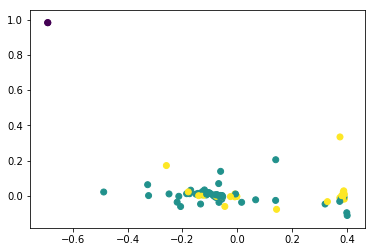

In [2]:
from sklearn import cluster
ncluster=3
k_means = cluster.KMeans(n_clusters=ncluster) # clustering model
k_means.fit(features) # fit model to data
print("Points per cluster=",[sum(1 for i in k_means.labels_ if i==k) for k in range(ncluster)])
plt.scatter(features.values.dot(Vx),features.values.dot(Vy),c=k_means.labels_)

### Writing our own k-means algorithm
The basic algorithm is very simple - so simple that we can write our own
```
Pick an initial assignment of points to clusters (or an initial set of centres of the clusters)
Repeat until converged:
    Assign each point to the nearest centre (euclidean distance)
    Move the center of each cluster to the centroid (average of all points in the cluster)
```

This method is a heuristic: It is not guaranteed to give an optimal solution (the one with the least average distance of points to their centre) and it will converge to different solutions depending on the initial solution we start with.

Some usuful numpy funtions
* `np.random.randint(low,high,n)` returns array length n of integers in `range(low,high)`
* `np.mean(matrix,axis=d)` = array of means (along either columns or rows depending on axis
* `np.linalg.norm` = norm of an array
* `np.argmin(matrix,axis=d)` = like mean iterates over elements along just one axis and returns the minimum index
* `X[v > 0]` - returns a submatrix of X depending on which elements of `v` are positive. Whether `v` may be of length number of rows (to select whole rows) or same dimension as X (to select submatrix). Similarly `X[:,v>0]` would select submatrix based on columns where `v` is positive.

Points per cluster= [50, 26, 11]


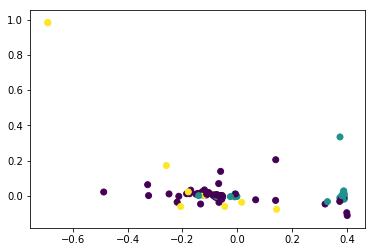

In [4]:
import numpy as np
def kmeansHeur(data,p):
    """Given a n x m matrix with n points and m features 
    return list/np.array length n of labels (in range(p))  
    """
    data = np.array(data) # just to make convert from any other data type
    n,m = data.shape
    lbl = np.random.randint(0,p,n)
    N,P = range(n),range(p)
    for iter in range(2):
        centre = [np.mean(data[lbl==k],axis=0) for k in P]
        dist = np.array([[ np.linalg.norm(data[i,:]-centre[k]) for k in P] for i in N])
        lblNew = np.argmin(dist,axis=1)
        if np.all(lblNew == lbl): break
        lbl = lblNew
    return lbl

lblsHeur = kmeansHeur(features,ncluster) # fit model to data
print("Points per cluster=",[sum(1 for i in lblsHeur if i==k) for k in range(ncluster)])
plt.scatter(features.values.dot(Vx),features.values.dot(Vy),c=lblsHeur)

This answer is probably not the same that you got wiht KMeans from sklearn. Which one is "right" or at least "better"? Need to formally define the objective function that we are trying to optimise. Essentially we are minimising the sum of squared norm distances:
$$\min_{c_k,C_k} \sum_k \sum_{i\in C_k} ||c_k - x_i||^2$$
Where $c_k$ and $C_k$ are the centre of cluster $k$ and the set of points in the cluster respectively. Each $x_i$ is a point of the data.

Compute the objective function for both your solution and the KMeans solution. Which one is better? Is either of these optimal (and how would we know?)

In [5]:
def clusterObj(data,label):
    "Input: feature matrix (pts x features) and label for each feature."
    data = np.array(data)
    P = set(label) # unique labels
    centre = [np.mean(data[label==k],axis=0) for k in P]
    return sum(np.linalg.norm(data[i,:]-centre[k])**2  for i,k in enumerate(label))
clusterObj(features,k_means.labels_),clusterObj(features,lblsHeur)

(35.92617097573589, 44.328479351670445)

In [7]:
print("sklearn soln:",clusterObj(features,k_means.labels_))
bestVal,bestLbl=1e99,lblsHeur
for itr in range(500):
    lblsHeur = kmeansHeur(features,ncluster) 
    obj = clusterObj(features,lblsHeur)
    if obj < bestVal: bestVal,bestLbl = obj,lblsHeur
print("best random:",bestVal)

sklearn soln: 35.92617097573589
best random: 35.17680710728231


### Exact optimisation
Documentation of the optimisation engines available via the [docplex](http://ibmdecisionoptimization.github.io/docplex-doc/) library (academic license availalbe and installed on maxima). The [examples](https://github.com/IBMDecisionOptimization/docplex-examples/tree/master/examples/cp/jupyter) provided by IBM include many jupyter notebooks.  An overview of [constraint types](http://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#module-docplex.cp.modeler) available is found here.

In [70]:
# Constraint programming optimisation model
import docplex.cp.model as CP
D = np.array(features)
mdl = CP.CpoModel() # create constraint programming model
N,P = range(len(lblsHeur)),range(3)
x = [CP.binary_var_list(3) for i in N] 
# assign each point to a cluster with each cluster non-empty
for i in N: mdl.add( sum(x[i][k] for k in P) == 1)
for k in P: mdl.add( sum(x[i][k] for i in N) >= 1)
centre = [np.mean(D[bestLbl==k],axis=0) for k in P]
mdl.add(CP.minimize(
    sum( (D[i,k]-centre[k])**2*x[i][k] for k in P for i in N)
))
mdl.solve() # not happy even with this not quite right version


ERROR: <ipython-input-70-2c457de668b2>:12(stream:371:390): Error: No matching operator for 'floatArray * intExpr'. Candidates are:
ERROR: <ipython-input-70-2c457de668b2>:12(stream:371:390): Error:    intExpr = intExpr * intExpr
ERROR: <ipython-input-70-2c457de668b2>:12(stream:371:390): Error:    floatExpr = floatExpr * floatExpr


LocalSolverException: Solver error: Error reading model from <stream> (<ipython-input-70-2c457de668b2>:12(stream:371:390): Error: No matching operator for 'floatArray * intExpr'. Candidates are:)

First attempt:  Solve as a quadratic mixed integer program.
* `import docplex.mp.model as MIP`
* `mdl = MIP.Model()` create an optimisation model
* `x = mdl.binary_var_list(n)` create list of variables `x[0]`...`x[n-1]` that are all in {0,1}
* `x = mdl.continuous_var_list(n,lb=0,ub=3*np.ones(n))` create list of variables `0<= x[i] <= 3` for i=0,...,n-1
* `mdl.add( mld.sum(x[i] for i in range(n)) == 1)` add the constraint $\sum_{i=0}^{n-1} x_i=1$
* `mdl.minimise( x[0]+x[1]**2)` set the objective (linear + quadratic term)
* `CPXparam = mdl.context.cplex_parameters` access parameters - complete list of [CPLEX parameters](https://www.ibm.com/support/knowledgecenter/SSSA5P_12.8.0/ilog.odms.cplex.help/CPLEX/Parameters/topics/introListAlpha.html). The important thing is to set: `CPXparam.timelimit=20` seconds, `CPXparam.threads=2` or similar as otherwise it may run for a very long time.


In [78]:
# Mathematical programming optimisation model
import docplex.mp.model as MIP
D = np.array(features)
mdl = MIP.Model() # create mixed integer programming model
N,P = range(len(lblsHeur)),range(3)
rng = np.max(D,axis=0)-np.min(D,axis=0)
x = [mdl.binary_var_list(len(P)) for i in N] 
y = [mdl.continuous_var_list(D.shape[1],lb=0,ub=rng) for i in N]
z = [mdl.continuous_var_list(D.shape[1],lb=np.min(D,axis=0),ub=np.max(D,axis=0)) for k in P] # center
# assign each point to a cluster with each cluster non-empty
for i in N: mdl.add( mdl.sum(x[i][k] for k in P) == 1)
for k in P: mdl.add( mdl.sum(x[i][k] for i in N) >= 1)
Mn,Mx = np.min(D,axis=0),np.max(D,axis=0)
for i in N:
    for k,M in enumerate(rng):
        for j in P:
            mdl.add( y[i][k] >= z[j][k] - D[i,k] - (Mx[k]-D[i,k])*(1-x[i][j]))
            mdl.add( y[i][k] >= D[i,k] - z[j][k] - (D[i,k]-Mn[k])*(1-x[i][j]))
#F = range(len(rng))
#for i in N:
#    for j in N[i+1:]:
#        for k in P:
#            for f in F:
#                mdl.add(y[i][f]+y[j][f] >= abs(D[i,f]-D[j,f])*(x[i][k]+x[j][k]-1))
mdl.minimize(
    mdl.sum( y[i][k]**2 for k in range(len(rng)) for i in N)
)
CPXparam = mdl.context.cplex_parameters
CPXparam.timelimit = 20
CPXparam.threads = 2
#for p in [CPXparam.timelimit, CPXparam.threads]: print(p.get_qualified_name()," = ",p.get())
#mdl.solve(log_output=True) # log_output = write to screen


How do we make this go faster?  Perhaps pass in a solution we have found already - just need to define the binary variables. Essential functions
* `soln = docplex.mp.solution.SolveSolution(mdl)` create a solution object for the model
* `soln.add_var_value(x[i][j],1)` sets the given variable to 1
* `soln.check_as_mip_start()` Is this a valid solution?
* `mdl.add_mip_start(soln)` Use the solution as a warm start for the optimisation
* `mdl.solve()` start/continue the optimisation

In [79]:
soln = docplex.mp.solution.SolveSolution(mdl)
lbls = k_means.labels_
for i in N:
    for k in P: 
        soln.add_var_value(x[i][k], (1 if lbls[i]==k else 0))
soln.check_as_mip_start()

True

We can arbitrarily assign at least one point to a cluster - since renumbering the clusters gives us equivalent solutions, this just breaks the symmetry.
Furthermore the two points furthest appart are definitely going to be in different clusters. So assign these two points to different clusters (actual cluster numbers should match the heuristic solution)

In [80]:
maxD,max_i,max_j = max( (np.linalg.norm(D[i,:]-D[j,:]),i,j) for i in N for j in N[i+1:])
print("Max distance %d <-> %d = %f"%(max_i,max_j,maxD))
mdl.add(x[max_i][lbls[max_i]]==1)
mdl.add(x[max_j][lbls[max_j]]==1)
mdl.add_mip_start(soln)
CPXparam.mip.strategy.heuristicfreq=1
#CPXparam.mip.strategy.rinsheur=1
soln = mdl.solve(log_output=True)

Max distance 19 <-> 32 = 2.534958
CPXPARAM_TimeLimit                               20
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 2
CPXPARAM_MIP_Strategy_HeuristicFreq              1
CPXPARAM_MIP_Strategy_RINSHeur                   1
1 of 1 MIP starts provided solutions.
MIP start 'm1' defined initial solution with objective 35.6424.
Tried aggregator 2 times.
MIQP Presolve eliminated 1741 rows and 6 columns.
Aggregator did 18 substitutions.
Reduced MIQP has 7207 rows, 1767 columns, and 21671 nonzeros.
Reduced MIQP has 255 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 1479 nonzeros.
Presolve time = 0.04 sec. (12.73 ticks)
Probing time = 0.00 sec. (0.60 ticks)
Tried aggregator 1 time.
Reduced MIQP has 7207 rows, 1767 columns, and 21671 nonzeros.
Reduced MIQP has 255 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 1479 nonzeros.
Presolve time = 0.02 sec. (7.07 

### Attempt 2 

This might just not work :-(  

## Supervised Learning - Classification with Support Vector Machines
We might want to figure out which algorithm works fastest for a given problem. That is, given a linear program and its characteristics, can we decide which algorithm to use to get the solution as fast as possible. Support vector machines are one model for such a classification task. It supposes that there is a _linear_ function of the factors that determines which of 2 classes a point belongs to. That is, that there exists a set of weights $w_i$ and constant $W$ such that
$\sum_i w_i f_i < W$ if one algorithm is faster and $\sum_i w_i f_i > W$ when the other method is faster where $f_i$ are the features of the instance we are interested in solving. How do we decide what the $w_i$ (and $W$) should be? This is supervised learning where we are using existing _training data_ to fit the parameters. 

Let's start by trying to work out for which instances the primal vs dual simplex method is faster. We have `primalT` and `dualT` that tells us which is faster for the test data. So we want to find a vector $w$ and constant $W$ such that
$\sum_i w_i f_{ki} \le W-1$ if `PrimalT` < `DualT` and $\sum_i w_i f_{ki} \ge  W+1$ otherwise. (Where $f_{ki}$ is the i-th feature of instance k.  Finding such a set of $w_i$ and $W$ is just a linear programming problem. Some things we need to consider is: The limit of 1 is just to ensure we get some minimum separation (we could pick any number as multiplying each row by a constant would not change the problem other than to increase the non-zero difference between the LHS and W
* If the instances can be separated, we want to make the 2 hyperplanes (defined by the $\pm1$ on the right hand side) as far apart as possible(so that we get a clean separation). The separation distance is $2/||w||$. So maximising the separation is equivalent to $\min ||w||^2$ which gives us a quadratic program with linear constraints.
* It may not be possible to separate the points cleanly into two groups with a single hyperplane. Hence we might want to penalise any point that is mis-classified, perhaps based on how far it is away from the hyperplane. Let $v_k$ be the distance that point $k$ is away from the hyperplane then we might want to $\min ||w||^2 + \sum_k v_k$ with $\sum_i w_i f_{ki} \le W-1+v_k$,
* We can put the two objectives together - by noting that maximisation is the same as minimising the negative and placing greater priority on minimising violations:
$\min ||w||^2 + \alpha \sum_k v_k$ subject to $\sum_i w_i f_{ki} \le W+v_k-s$ for $k$ such that the primal solution is better (with correspoding $\ge$ constraints for the other points). Here $\alpha$ is an arbitrary weight that provides a trade-off between violations (misclassifications) and the distance separating the hyperplanes.
* Some variants of this are possible. For example we could replace the$||w||^2$ term by $\max_i |w_i|$ (for example) which can be written in a linear program, or even drop it entirely. When there are violations these are minimised  if $||w||$ is minimised so we may not need this.

Hence for an initial experiment we want to set up an SVM training function that takes our features as input data together with the list instances for which `data['PrimalT'] < data['dualT']` (this python expression returns a boolean column). Let `I` be those instances and `IC` be the complement. The we want to solve the following linear program:
$$\min_{v,w,W} \sum_{i\in I\cup IC} v_i$$
$$s.t.\ \sum_{k\in F} D_{if} w_f \le W - 1 + v_i\quad\forall\ i\in I$$
$$\quad \sum_{k\in F} D_{if} w_f \ge W + 1 - v_i\quad\forall\ i\in IC$$
$$ v_i \ge 0\quad\forall\ i$$
Here $D_{if}$ is the data for instance $i$ and feature $f$ out of the set of features $F$.

How to set this LP up using the CPLEX solver:
* `import docplex.mp.model as MP`
* `mdl = MP.Model()` create a mathematical programming (optimisation) model 
* `x = mdl.binary_var_list(n)` create list of variables `x[0]`...`x[n-1]` that are all in {0,1} - not needed here
* `x = mdl.continuous_var_list(n,lb=-mdl.infinity,ub=3*np.ones(n))` create list of variables $-\infty < x[i] \le 3$ for i=0,...,n-1
* `mdl.add( mdl.sum(x[i] for i in range(n)) == 1)` add the constraint $\sum_{i=0}^{n-1} x_i=1$
* `mdl.minimize( x[0]+x[1]**2)` set the objective (linear + quadratic term). Note: CPLEX handles quad
* `CPXparam = mdl.context.cplex_parameters` access parameters - complete list of [CPLEX parameters](https://www.ibm.com/support/knowledgecenter/SSSA5P_12.8.0/ilog.odms.cplex.help/CPLEX/Parameters/topics/introListAlpha.html). It may be a good idea to set `CPXparam.timelimit=60` seconds (to stop it running too long if the problem is not set up correctly), `CPXparam.threads=1`. This model should run in no more than a second though.
* `solution = mdl.solve(log_output=True)` does the optimisation and shows logs some information to the screen as it runs
* `mdl.get_solve_status()` gives the final solution status (as a string)
* `solution.get_value(x[0]+x[1])` would return the final value of `x[0]+x[1]` in the solution. Alternatively you can also use `solution[x[2]]` to get the value of `x[2]` in the solution. (More informmation on the solution class see [SolveSolution](http://ibmdecisionoptimization.github.io/docplex-doc/mp/docplex.mp.solution.html#docplex.mp.solution.SolveSolution))



In [51]:
# Mathematical programming optimisation model
import docplex.mp.model as MP

def SVM(features,label):
    """features: the usual matrix of points x features
    label: a list/array (length number of points) of bools/integers that
           identifies the points to be separated from the rest
    Returns: array length n.features+1 of w_i plus the constant W"""
    label = np.array(label) # to make sure we are not dealing with DataFrames
    D = np.hstack([np.array(features),-np.ones((len(label),1))]) # append a column of -1
    N,F=range(len(label)),range(D.shape[1])
    mdl = MP.Model() # create linear programming model
    w = mdl.continuous_var_list(len(F),lb=-mdl.infinity)
    v = mdl.continuous_var_list(len(N),lb=0)
    mdl.minimize( mdl.sum(v[i] for i in N) )
    for i in N:
        if label[i]:
            mdl.add( mdl.sum(D[i,k]*w[k] for k in F) <= v[i]-1)
        else:
            mdl.add( mdl.sum(D[i,k]*w[k] for k in F) >= 1-v[i])
    solution = mdl.solve(log_output=True)
    print("Solved with status",mdl.get_solve_status())
    if not solution:
        print("ERROR: can't get solution")
        mdl.report()
        return []
    vv = [ solution[v[i]] for i in N]
    print("Total violation = ",sum(vv),
         "%d/%d points misclassified"%(len([1 for i in N if label[i] and vv[i]>0.99]),
                                      len([1 for i in N if not label[i] and vv[i]>0.99])),
         "out of",len(label))
    print("Separation = ",1/sum(solution[w[i]]**2 for i in F)**0.5)
    return [solution.get_value(w[f]) for f in F]
soln = SVM(features,data['PrimalT']<data['DualT'])
print("Weights =",soln)

CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 0 rows and 15 columns.
Reduced LP has 87 rows, 90 columns, and 1200 nonzeros.
Presolve time = 0.00 sec. (0.16 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             0.000000
Iteration:    62   Dual objective     =            42.081019
Solved with status JobSolveStatus.OPTIMAL_SOLUTION
Total violation =  54.59659951204999 14/12 points misclassified out of 87
Separation =  0.0013396660099036803
Weights = [-533.9365967182416, 90.28188241112247, 493.6059901185694, 31.377340984067423, 0, 34.65769774798712, 67.28892874907928, -19.023946114591265, -26.38250612429877, 102.40045609618157, 44.35318327509701, 2.559923016240604, 7.840970481106403, 3.8809909572742054, 0.7927403279272234, 0.6455098523754619, 0.09559570656965322, 0.02152710907253394]


What can we do to improve the fit? How to deal with non-linear separations? Try adding additional "features" that capture the non-linear effects. For example we might expect that the effectiveness depends on the size or density of the constraint matrix (density = 'ConNZ' / ('VarCnt' x 'ConCnt')). Create an extended feature set and try again.
The idea here is that if we have say a two dimensional set of features (x,y for each point) and we wanted to separate those points that are inside an elipse centered at the origin from those outside, then we can find such a separating elipse by including features $x^2$ and $y^2$ with the optimisation choosing some combination $w_x x^2 + w_y y^2 \le W$ giving us an elipse while still solving a lienar problem (since the $x^2$ is just a constant coefficent for the variable $w_x$ in the optimisation).

Try creating some additional features. Remember for `DataFrames` we can easily create new columns by doing arithmetic with whole columns. For example `features['eqSq'] = features['ConEqual']**2` would create a new column `eqSq` that contains the number of equality constraints (`ConEqual`) squared. 

In [50]:
expFeat = features.copy()
expFeat['MatSize'] = expFeat['VarCnt']*expFeat['ConCnt']
expFeat['dense'] = expFeat['ConNZ'] / expFeat['MatSize']
expFeat['Size2'] = expFeat['MatSize']*expFeat['MatSize']
expFeat['MatRatio'] = expFeat['VarCnt']/expFeat['ConCnt']
expFeat['MatRatio2'] = expFeat['MatRatio']*expFeat['MatRatio']
expFeat['dense2']= expFeat['dense']*expFeat['dense']
for f in expFeat:#['MatSize','dense','Size2','dense2']: # scale features
    expFeat[f] /= max(abs(expFeat[f]))
expSoln = SVM(expFeat,data['PrimalT']<data['DualT'])

CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 0 rows and 17 columns.
Reduced LP has 87 rows, 94 columns, and 1720 nonzeros.
Presolve time = 0.01 sec. (0.23 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             0.000000
Iteration:    62   Dual objective     =            22.088942
Solved with status JobSolveStatus.OPTIMAL_SOLUTION
Total violation =  44.75434493600261 14/9 points misclassified out of 87
Separation =  0.0003417619798857912


#### How well is our classifier doing?
To analyse the performance we should think about:
* Do we care about:
    1. how far we are on the wrong side of the line? (this is what we are optimising at the moment)
    2. how many instances are classified incorrectly?
    3. how much extra compute time we would incur if we used the minimum?
* How well it works for data it hasn't seen?
    
Below compute some alternative measures of the quality of the fit. Then address the second issue by using a random split of the instances to create 4 groups (of about 21 each). Then we used 3 parts as the "training" data to fit the SVM model, and the other group for testing to validate that the model is acutally OK on data that wasn't used for the training. By repeating this 4 times for each group we can compute a more accurate average performance of the approach on this type of data.

In [68]:
def SVMviolation(feat,w,lower=data['PrimalT'],higher=data['DualT']):
    """Input: feat = matrix of features, w - list/array of weights (length features + 1), 
     higher/lower = performance measure
     Returns total violation of sum( w[i]*feat[i]) <= W or >= W depending on if lower[i] < or > higher[i]"""
    feat = np.array(feat) # just to make sure it is not a DataFrame
    v = feat.dot(np.array(w[:-1])) - w[-1]*np.ones(feat.shape[0])
    L = [ i for i,(low,high) in enumerate(zip(lower,higher)) if low < high]
    H = [ i for i,(low,high) in enumerate(zip(lower,higher)) if low > high]
    return sum( max(0,v[i]) for i in L)+sum(max(0,-v[i]) for i in H)
def SVMextraT(feat,w,lower=data['PrimalT'],higher=data['DualT']):
    """Input: feat = matrix of features, w - list/array of weights (length features + 1), 
     higher/lower = performance measure  (if feat * w < W we run the 'lower' method)
     Returns total extra time for running the slower algorithm"""
    v = np.array(feat).dot(np.array(w)[:-1])
    return sum(  max(0,low-high) if v[i] < 0 # extra time for low (Primal) algorithm if this is slower
               else max(0,high-low) # extra time to run the Dual (high) alg. if this is slower
        for i,(low,high) in enumerate(zip(lower,higher)) )
def SVMcount(feat,w,lower=data['PrimalT'],higher=data['DualT']):
    """Input: feat = matrix of features, w - list/array of weights (length features + 1), 
     higher/lower = performance measure  (if feat * w < W we run the 'lower' method)
     Returns total extra time for running the slower algorithm"""
    v = np.array(feat).dot(np.array(w)[:-1])
    return sum( 1 for i,(low,high) in enumerate(zip(lower,higher))
               if (low-high)*v[i] < 0 ) # mis-classified if low > high & v[i]<0 or low > high & v[i]>0

print("Results from training on whole data")
print("Effectiveness of solution: %.2f viol, %.2f ticks, %d misclassified"%(
    SVMviolation(features,soln),SVMextraT(features,soln),SVMcount(features,soln)))
print("Expanded feature set soln: %.2f viol, %.2f ticks, %d misclassified"%(
    SVMviolation(expFeat,expSoln),SVMextraT(expFeat,expSoln),SVMcount(expFeat,expSoln)))


Results from training on whole data
Effectiveness of solution: 17.18 viol, 8374.41 ticks, 23 misclassified
Expanded feature set soln: 16.05 viol, 754.89 ticks, 18 misclassified


In [87]:
# do things correctly using a subset of data for training only
def SVMtest(feat,nGroup=4,method=SVM,lower=data['PrimalT'],higher=data['DualT']):
    """Split features feat into nGroup groups, train using method, evaluate using lower/higher"""
    rows = feat.index
    randsel = np.random.randint(0,nGroup,len(rows))
    grps = [ [r for i,r in enumerate(rows) if randsel[i]==g] for g in range(nGroup)] 
    v,t,c = 0,0,0
    for g in range(nGroup):
        train = sum( (grps[i] for i in range(nGroup) if i!=g), []) # join all groups
        test = grps[g]
        w = method(feat.loc[train],lower[train] < higher[train])
        v += SVMviolation(feat.loc[test],w,lower[test],higher[test])
        t += SVMextraT(feat.loc[test],w,lower[test],higher[test])
        c += SVMcount(feat.loc[test],w,lower[test],higher[test])
    print("Performance with",nGroup,"groups:"
          "%.2f viol, %.2f ticks, %d misclassified"%(v,t,c))
    return v,t,c
SVMtest(features)
SVMtest(expFeat)

CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 2 rows and 18 columns.
Aggregator did 1 substitutions.
Reduced LP has 55 rows, 57 columns, and 745 nonzeros.
Presolve time = 0.00 sec. (0.14 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             0.000000
Solved with status JobSolveStatus.OPTIMAL_SOLUTION
Total violation =  25.846194539417073 7/3 points misclassified out of 58
Separation =  0.0001707715384478243
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 2 rows and 14 columns.
Reduced LP has 68 rows, 74 columns, and 920 nonzeros.
Presolve time = 0.00 sec. (0.13 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             0.000000
Iteration:    62   Dual objective     =            33.875482
Solved with status JobSolveStatus.OPTIMAL_SOLUTION
Total violation =  34.94454272

(1125.871757496142, 9787073.669999996, 36)

### Extension exercises
* We could modify our SVM approach to use an objective that better matches what we want to achieve (e.g. minimise additional computational effort from misclassified instances)
* Use the sklearn builtin method `LinearSVC` to implement a support vector machine. Documentation is available [here](https://scikit-learn.org/stable/modules/svm.html) The basic approach is:
```python
from sklearn import svm
mdl = svm.LinearSVC()
mdl.fit(X,y) # X = training data, y is -1 when PrimalT < DualT and +1 otherwise
mdl.predict(x) # predict outcome using test data x
```